In [23]:
import pandas as pd


In [24]:
scored_variants = pd.read_csv("/mnt/lab_data2/anusri/signed_variant_scorer/variant-scorer/output/blood_traits/DNASE/summary.mean.variant_scores.tsv", sep="\t", header=0)


In [25]:
import matplotlib


matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams['figure.figsize'] = [12, 10]

def plot_enrichment_curves(df, compare_score, model_score, output_file, compare_score_ascending=False, model_score_ascending=True,
                           thresh_list=[0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], subsample=False, ymax='auto', debug=False):
    by_thresh_dict = {'score':[], 'ratio':[], 'thresh':[]}
    
    df[model_score+"_abs"] = np.abs(df[model_score])
    model_score = model_score+"_abs"
    print(model_score)
    thresh_list = [df[model_score].quantile(1-0.5), df[model_score].quantile(1-0.1), df[model_score].quantile(1-0.05), df[model_score].quantile(1-0.01),
                  df[model_score].quantile(1-0.005), df[model_score].quantile(1-0.001), df[model_score].quantile(1-0.0005), df[model_score].quantile(1-0.0001)]
    print(thresh_list)
    for thresh in thresh_list:
        df[compare_score].fillna(0, inplace=True)
        sample_df = df.sort_values(by=[compare_score, model_score], ascending=[False, False])
        #print(sample_df.head())
        #print(sample_df.tail())
        ratio = len(sample_df.loc[sample_df[model_score] > thresh]) / len(sample_df)
        sample_df['sig'] = sample_df[model_score].apply(lambda x: x > thresh)
        sample_df['expected'] = [ratio] * len(sample_df)
        expected = sample_df['expected'].cumsum().tolist()
        observed = sample_df['sig'].cumsum().tolist()
        
        enrich_ratio = np.array(observed) / np.array(expected)
        compare_vals = sample_df[compare_score].tolist()
        enrich_ratio = enrich_ratio.tolist()
        assert len(compare_vals) == len(enrich_ratio)
        by_thresh_dict['ratio'].extend(enrich_ratio)
        by_thresh_dict['score'].extend(compare_vals)
        by_thresh_dict['thresh'].extend([thresh] * len(sample_df))
        
        if debug:
            print(thresh)
            print('Expected:', expected[:10])
            print('Observed:', observed[:10])
            print('Ratio:', enrich_ratio[:10])
            print('Compare Scores:', compare_vals[:10])
            print()
        
    by_thresh_df = pd.DataFrame(by_thresh_dict)
    by_thresh_df.sort_values(by=['score'], ascending=False, inplace=True)
    if subsample:
        by_thresh_df = pd.concat([by_thresh_df.iloc[:20000,].copy(), by_thresh_df.iloc[20000:,].copy().sample(30000)])
    ax = sns.lineplot(data=by_thresh_df, x='score', y='ratio', linewidth=3,  ci=None,
                      hue='thresh', palette=sns.color_palette('rocket', 8))
    leg = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    for line in leg.get_lines():
        line.set_linewidth(4)
    if str(ymax) != 'auto':
        ax.set(title=compare_score + ' vs ' + model_score, xlabel=compare_score, ylabel='observed / expected', ylim=(0, ymax))
    else:
        ax.set(title=compare_score + ' vs ' + model_score, xlabel=compare_score, ylabel='observed / expected')
    plt.savefig("subfigs/"+output_file, transparent=True, dpi=300)

In [26]:
scored_variants

,chr,pos,allele1,allele2,variant_id,logfc.mean,logfc.mean.pval,abs_logfc.mean,abs_logfc.mean.pval,jsd.mean,...,abs_logfc_x_jsd.mean,abs_logfc_x_jsd.mean.pval,logfc_x_max_percentile.mean,logfc_x_max_percentile.mean.pval,abs_logfc_x_max_percentile.mean,abs_logfc_x_max_percentile.mean.pval,jsd_x_max_percentile.mean,jsd_x_max_percentile.mean.pval,abs_logfc_x_jsd_x_max_percentile.mean,abs_logfc_x_jsd_x_max_percentile.mean.pval
0,chr1,10352,T,TA,rs150218945,0.004799,0.803472,0.006247,0.813983,0.013399,...,0.000092,0.661887,0.003106,0.237067,0.004224,0.243506,0.009301,0.037282,0.000059,0.219019
1,chr1,11012,C,G,rs544419019,0.008337,0.501628,0.019329,0.509061,0.031942,...,0.000591,0.230600,0.005817,0.089925,0.016318,0.091626,0.026242,0.007068,0.000489,0.061075
2,chr1,13110,G,A,rs540538026,-0.000662,0.846653,0.005267,0.847730,0.004676,...,0.000025,0.885257,0.000135,0.672039,0.000236,0.672124,0.000265,0.556792,0.000001,0.727699
3,chr1,13116,T,G,rs62635286,0.007013,0.696392,0.011120,0.702143,0.005918,...,0.000088,0.713836,0.000096,0.575753,0.000408,0.577936,0.000286,0.533121,0.000002,0.620976
4,chr1,13118,A,G,rs200579949,0.013721,0.599011,0.013721,0.616948,0.006579,...,0.000090,0.638957,0.000946,0.457383,0.000946,0.470506,0.000436,0.486234,0.000006,0.504230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11916119,chr21,46697787,C,G,rs11910421,0.010449,0.583465,0.015434,0.596975,0.011338,...,0.000202,0.485783,0.006085,0.161308,0.007695,0.167522,0.005723,0.074639,0.000103,0.174837
11916120,chr21,46698531,T,G,rs533222456,0.009265,0.544551,0.017547,0.549907,0.014943,...,0.000264,0.417207,0.006071,0.125662,0.012249,0.125433,0.010867,0.029458,0.000182,0.122447
11916121,chr21,46699340,G,A,rs199868906,-0.165428,0.038045,0.165428,0.036121,0.084160,...,0.014064,0.016019,-0.098447,0.016582,0.098447,0.015905,0.040058,0.004275,0.008240,0.009140
11916122,chr21,46699340,G,T,rs199868906,-0.127152,0.061514,0.127152,0.058221,0.073736,...,0.009476,0.024382,-0.074931,0.024229,0.074931,0.023196,0.034284,0.005575,0.005406,0.013319


In [27]:
#blood_variants=pd.read_csv("/mnt/lab_data2/anusri/signed_variant_scorer/variant-scorer/output/blood_traits/SNP_info_table.tsv", sep="\t", header=0)
blood_variants=pd.read_csv("/oak/stanford/groups/akundaje/projects/igvf-fcc/data/rosa/SNP_info_table.blood.superset.tsv", sep="\t", header=0)

In [28]:
def flatten(l):
    return [item for sublist in l for item in sublist]

import numpy as np


set(flatten(blood_variants['traits'].str.split("|").values.tolist()))

{'Hb', 'HbA1c', 'MCH', 'MCHC', 'MCV', 'Plt', 'RBC', 'WBC'}

In [29]:
blood_variants

,rsid,allele1,allele2,traits,IDs,maxPIP
0,rs10000067,T,C,MCH,MCH_rs10000067,0.007929
1,rs10000173,A,G,MCH|MCV|Plt,MCH_rs10000173|MCV_rs10000173|Plt_rs10000173,0.002267
2,rs10000282,T,C,Hb,Hb_rs10000282,0.050462
3,rs10000324,A,T,Hb,Hb_rs10000324,0.066452
4,rs10000348,G,T,Plt,Plt_rs10000348,0.081643
...,...,...,...,...,...,...
83264,rs9999602,T,C,Plt,Plt_rs9999602,0.002586
83265,rs9999724,C,T,MCV,MCV_rs9999724,0.003559
83266,rs9999824,A,C,Plt,Plt_rs9999824,0.036966
83267,rs9999865,T,C,WBC,WBC_rs9999865,0.003355


In [30]:
final = scored_variants.merge(blood_variants, how="left", left_on=["variant_id", "allele1", "allele2"], right_on=["rsid", "allele1", "allele2"])



In [31]:

final.count()

chr                                           11916124
pos                                           11916124
allele1                                       11916124
allele2                                       11916124
variant_id                                    11916124
logfc.mean                                    11916124
logfc.mean.pval                               11916124
abs_logfc.mean                                11916124
abs_logfc.mean.pval                           11916124
jsd.mean                                      11916124
jsd.mean.pval                                 11916124
logfc_x_jsd.mean                              11916124
logfc_x_jsd.mean.pval                         11916124
abs_logfc_x_jsd.mean                          11916124
abs_logfc_x_jsd.mean.pval                     11916124
logfc_x_max_percentile.mean                   11916124
logfc_x_max_percentile.mean.pval              11916124
abs_logfc_x_max_percentile.mean               11916124
abs_logfc_

logfc.mean_abs
[0.01904852285999995, 0.07929850299, 0.1201951220999999, 0.2855402820599999, 0.39360816852999986, 0.7297315348960273, 0.9088736912690065, 1.3607140218648237]


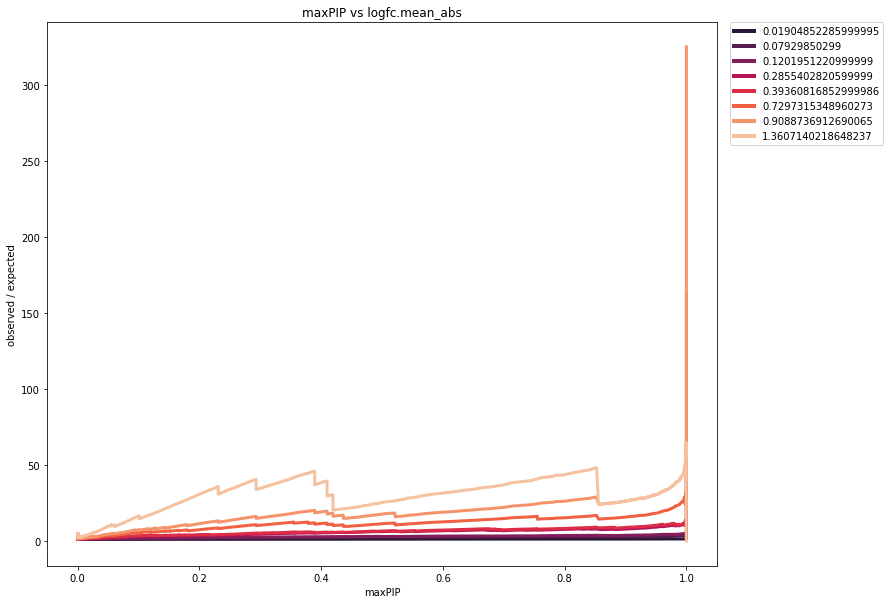

In [33]:
import numpy as np
import seaborn as sns

plot_enrichment_curves(final,
                       compare_score='maxPIP', model_score='logfc.mean',
                       compare_score_ascending=False, model_score_ascending=True, output_file="quantile_bloodtraits_abs_logfc_x_jsd_x_max_percentile.pdf")

abs_logfc_x_max_percentile.mean_abs
[0.0007361989384504, 0.01252151072751814, 0.0251514087651672, 0.08914626711658837, 0.13892922616784475, 0.333280412229654, 0.45508159517193886, 0.8214484225275]


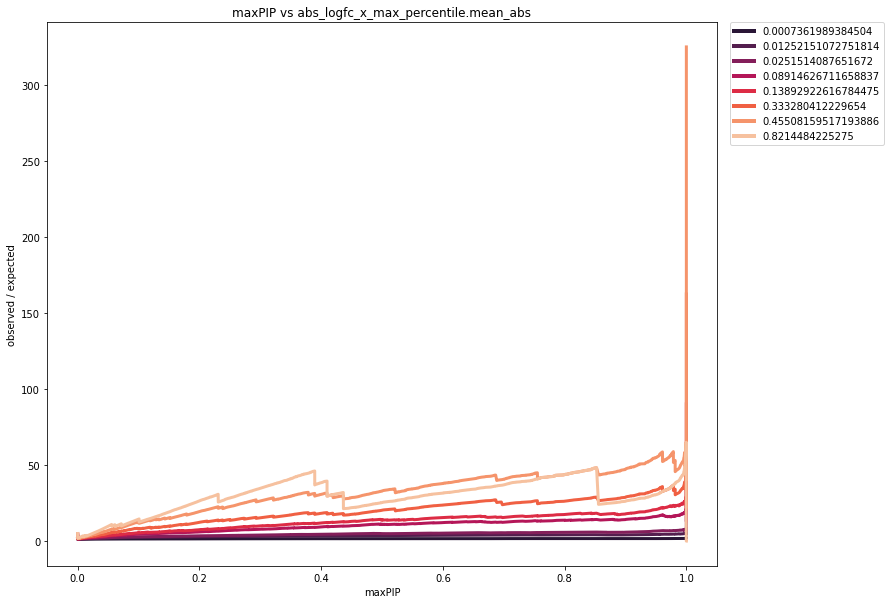

In [34]:
import numpy as np
import seaborn as sns

plot_enrichment_curves(final,
                       compare_score='maxPIP', model_score='abs_logfc_x_max_percentile.mean',
                       compare_score_ascending=False, model_score_ascending=True, output_file="quantile_bloodtraits_abs_logfc_x_jsd_x_max_percentile2.pdf")

abs_logfc_x_jsd_x_max_percentile.mean_abs
[6.394367149043575e-06, 0.0002138376304738011, 0.0006157235764704699, 0.004498019849713288, 0.009285159178243142, 0.03837451363441967, 0.0633847102465701, 0.1594215170877642]


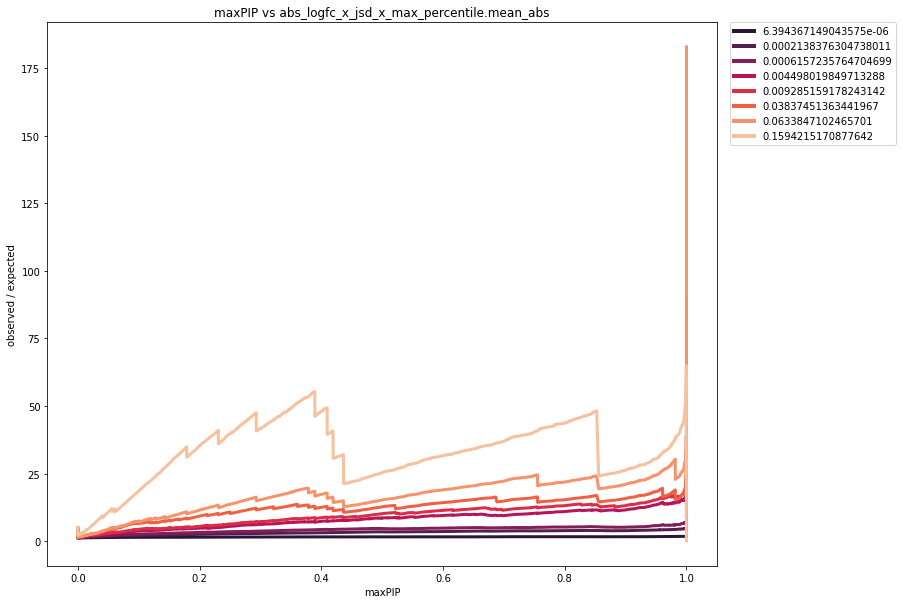

In [36]:

plot_enrichment_curves(final,
                       compare_score='maxPIP', model_score='abs_logfc_x_jsd_x_max_percentile.mean',
                       compare_score_ascending=False, model_score_ascending=True, output_file="temp.pdf")   

In [ ]:
plot_enrichment_curves(final,
                       compare_score='maxPIP', model_score='abs_logfc_x_max_percentile.mean.pval',
                       compare_score_ascending=False, model_score_ascending=True)

In [ ]:
plot_enrichment_curves(final,
                       compare_score='maxPIP', model_score='logfc_x_max_percentile.mean.pval',
                       compare_score_ascending=False, model_score_ascending=True)

In [ ]:
plot_enrichment_curves(final,
                       compare_score='maxPIP', model_score='abs_logfc_x_jsd.mean.pval',
                       compare_score_ascending=False, model_score_ascending=True)

In [ ]:
plot_enrichment_curves(final,
                       compare_score='maxPIP', model_score='logfc_x_jsd.mean.pval',
                       compare_score_ascending=False, model_score_ascending=True)

In [ ]:
plot_enrichment_curves(final,
                       compare_score='maxPIP', model_score='logfc.mean.pval',
                       compare_score_ascending=False, model_score_ascending=True)

In [ ]:
plot_enrichment_curves(final,
                       compare_score='maxPIP', model_score='abs_logfc.mean.pval',
                       compare_score_ascending=False, model_score_ascending=True)                                                           


In [ ]:
plot_enrichment_curves(final,
                       compare_score='maxPIP', model_score='jsd.mean.pval',
                       compare_score_ascending=False, model_score_ascending=True)                                                           
